# Predicting Earthquake Damage Grade Levels Using Classification
##### Allison King
##### STAT 6309

## Introduction

In April of 2015, there was a major earthquake near the Gorkha district of Gandaki Pradesh, Nepal that reached a magnitude of 7.6 and impacted almost one-third of the population. Approximately 9,000 people were killed, over 100,000 people were injured, 500,000 plus homes were destroyed and another 269,000 damaged [1]. This left a sizeable chunk of the population instantly homeless and destitute. 

There is a common saying "Earthquakes don't kill people, buildings do." I was curious to analyze any known building qualities, such as the number of floors or foundation type of the building, that contribute to buildings being destroyed during earthquakes. Upon a quick Google Search, within seconds I found the Federal Emergency Management Agency's (FEMA) web page on seismic building codes. There are three types of codes - the International Building Code (IBC), International Residential Code (IRC), and International Existing Building Code (IEBC) [2]. As there is an extensive amount of information that's available on FEMA's website, I am doubtful that the architects and civil engineers in Nepal followed any comparable guidelines when building these structures given the numbers discussed in the previous paragraph. 

Furthermore, FEMA states that "certain types of buildings, such as unreinforced masonry structures, have performed poorly in past earthquakes and are known to be particularly hazardous" [2]. Optimum Seismic additionally concludes that the following five building types have been proven to be vulnerable in the face of an earthquake: soft-story, tilt-up, non-ductile concrete, steel moment frame, and unreinforced masonry [3]. In order to help prevent a tragedy like this in the future, I wanted to see what features, if any, contribute to a structure being less stable in the face of an earthquake with high magnitude. Examples of potential contributing factors are the number of floors, the type of foundation of the building, the type of ground floor, etc. Thus, the goal of this project was to use classification to predict damage grade through Random Forest, k-Nearest Neighbor (kNN), and Support Vector Machine (SVM) models given a slew of input features relating to the structure/building type. This is important because it can help civil engineers, architects, and FEMA to create high standard building codes in order to prevent the intense level of impact a tragedy like the Gorkha earthquake had on thousands of people.

## Data Description

The "gorkha" dataset contains a total of 31 columns and is intended to encapsulate qualities relating to the structure of the damaged/destroyed buildings in the 2015 Gorkha earthquake. The first four columns of this dataset look at the building ID, district ID, the municipality where the building is located, and the ward ID. The fifth and sixth columns look at the count of floors before and after the earthquake. The seventh column is the age of the building. The eighth column ("plinth_area_sq_ft") is the area of the building that is not covered by floors. The ninth and tenth columns are the height of the building before and after the earthquake. The eleventh column ("land_surface_condition") is the slope of the land the building was built on. The twelth column ("foundation_type") is the type of foundation the building was built on. The thirteenth column is the type of roof associated with the building. The fourteenth column is the type of ground floor. The fifteenth column is an additional column for if there is another type of ground floor. The "position" column (the sixteenth), denotes if there is another structure attached to the building or not. The seventeenth column is the plan configuration of the building. The eighteenth through twenty-eigth columns are for if the building has various types of superstructures such as timber, cement, mud, etc. Worth noting, a "superstructure" is something built on top of something else. The twenty-ninth column looks at the condition of the building post earthquake. The thirtieth column, (our y-variable), is the damage rating/grade of the building after the earthquake. The last column is the technical solution proposed to fix the damage on the building.

The "location" dataset contains 5 columns and is mainly included for joining purposes. I'm hoping to join this dataset with the "gorkha" dataset in order to provide district and municipality names rather than just working with IDs. The first column is the ward ID. The second and third columns are the ID for the municipality where the building is located as well as the actual name of the municipality. The fourth and fifth columns are the district IDs and names.

In [2]:
#Load necessary packages
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.inspection import permutation_importance

In [3]:
#Import the datasets
gorkha = pd.read_csv("/Users/allisonking/Downloads/csv_building_structure.csv")
location = pd.read_csv("/Users/allisonking/Downloads/ward_vdcmun_district_name_mapping.csv")

#Join the datasets together by ward ID
new = gorkha.merge(location, on='ward_id', how='left')

#Drop ID columns
new = new.drop(columns=['district_id_y', 'vdcmun_id_y'])
print(new.head())

    building_id  district_id_x  vdcmun_id_x  ward_id  count_floors_pre_eq  \
0  120101000011             12         1207   120703                    1   
1  120101000021             12         1207   120703                    1   
2  120101000031             12         1207   120703                    1   
3  120101000041             12         1207   120703                    1   
4  120101000051             12         1207   120703                    1   

   count_floors_post_eq  age_building  plinth_area_sq_ft  height_ft_pre_eq  \
0                     1             9                288                 9   
1                     1            15                364                 9   
2                     1            20                384                 9   
3                     1            20                312                 9   
4                     1            30                308                 9   

   height_ft_post_eq  ... has_superstructure_timber has_superstructu

## Data Pre-Processing

To begin the preprocessing portion, I started by importing the proper packages and loading in the datasets. I then joined the building structure dataset with the location dataset through a left join and dropped the repetitive columns. Next, there appeared to be 12 rows of missing data. I performed simple imputation as this took care of the missing values for both the numeric and categorical columns. Simple imputation works by imputing the missing values with the most commonly seen value (mode). I tried to do KNN originally as this works for both numeric and categorical data in R, however for Python this only works with numeric data so I was not able to get it to run. I then removed all duplicate rows. Finally, I converted the necessary columns to numeric type as the simple imputation function I used converted all columns to object type originally.

In [4]:
#Check for missing data
print("The number of rows with at least one missing value is", new.isnull().any(axis=1).sum())
print(new.iloc[:,0:35].isnull().sum())

#Simple imputation for missing values
imp = SimpleImputer(strategy='most_frequent')
new1 = imp.fit_transform(new)
ndf = pd.DataFrame(new1, columns = new.columns)
print("The number of rows with at least one missing value is now", ndf.isnull().any(axis=1).sum())

#Remove any duplicates
ndf = ndf.drop_duplicates()

The number of rows with at least one missing value is 12
building_id                                0
district_id_x                              0
vdcmun_id_x                                0
ward_id                                    0
count_floors_pre_eq                        0
count_floors_post_eq                       0
age_building                               0
plinth_area_sq_ft                          0
height_ft_pre_eq                           0
height_ft_post_eq                          0
land_surface_condition                     0
foundation_type                            0
roof_type                                  0
ground_floor_type                          0
other_floor_type                           0
position                                   1
plan_configuration                         1
has_superstructure_adobe_mud               0
has_superstructure_mud_mortar_stone        0
has_superstructure_stone_flag              0
has_superstructure_cement_mortar_stone     

In [5]:
cols = ['count_floors_pre_eq', 'count_floors_post_eq', 'age_building', 
        'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq', 'has_superstructure_adobe_mud', 
        'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
        'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo',
        'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other']

#Convert object columns to numeric type
for c in cols:
    ndf[c] = ndf[c].apply(int)
    
ndf.select_dtypes(include=np.number)

,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
0,1,1,9,288,9,9,0,1,0,0,0,0,0,1,0,0,0
1,1,1,15,364,9,9,0,1,0,0,0,0,0,1,0,0,0
2,1,1,20,384,9,9,0,1,0,0,0,0,0,0,0,0,0
3,1,1,20,312,9,9,0,1,0,0,0,0,0,0,0,0,0
4,1,1,30,308,9,9,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,2,0,60,165,18,0,0,1,0,0,0,0,0,0,0,0,0
762102,2,0,35,342,18,0,0,1,0,0,0,0,0,0,0,0,0
762103,2,0,35,342,18,0,0,1,0,0,0,0,0,0,0,0,0
762104,2,0,19,306,18,0,0,1,0,0,0,0,0,0,0,0,0


## EDA

For the visualization portion, I began by creating a correlation matrix/heatmap of all of the numeric variables in the new dataset. A relationship that immediately stands out is the correlation between the count of floors post-earthquake and the building height post-earthquake. This makes sense as these two features may be redundant of each other. One may need to be removed during the model build out portion to avoid multicollinearity issues. Similarly, there also seems to be a strong relationship between the count of floors pre-earthquake and the building height pre-earthquake.

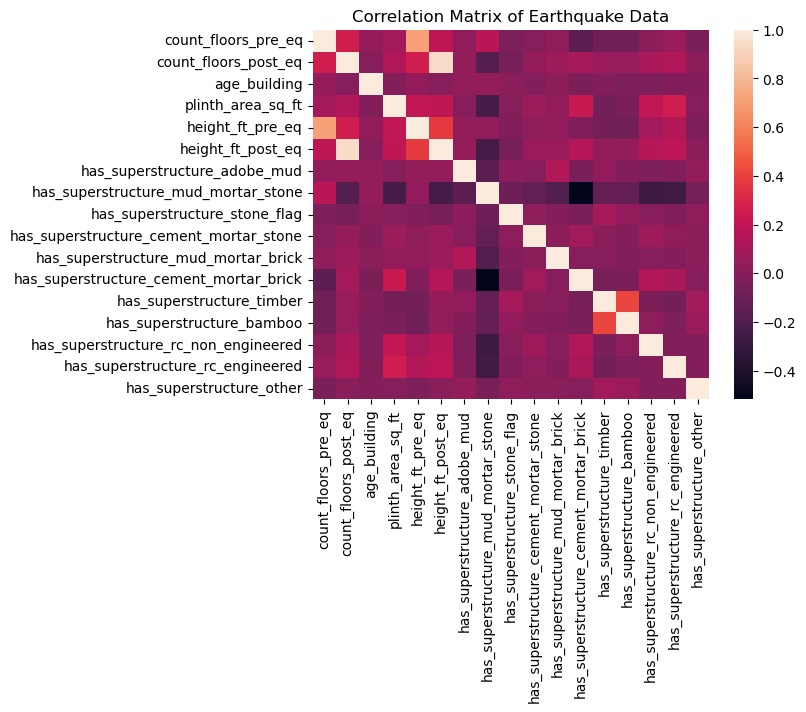

In [6]:
#Correlation matrix
corr_matrix = ndf.corr()

sns.heatmap(corr_matrix, annot=False)
plt.title("Correlation Matrix of Earthquake Data")
plt.show()

In the visual below, damage grade appears to have an exponential distribution with grade 5 having the highest frequency of buildings and grade 1 having the lowest. For context, grade 1 damage means there was little-no damage to the building, whereas grade 5 damage means there was substantial damage to the building. We can tell the Gorkha earthquake had devestating effects based on the frequencies of grades 4 and 5. Furthermore, this visual tells us there is a moderate class imbalance issue.

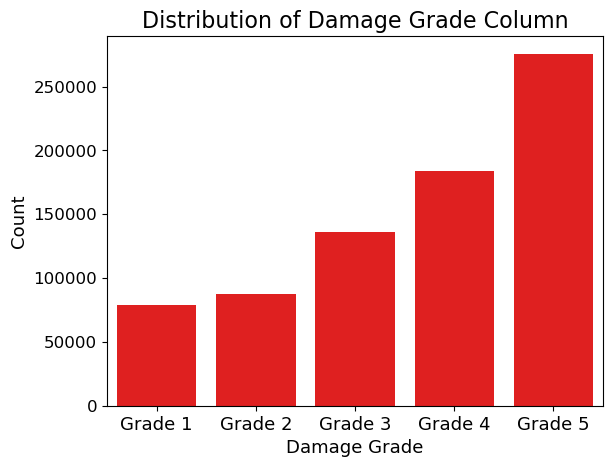

In [6]:
#Get value counts
ndf['damage_grade'].value_counts()

dict1 = ({'Grade 1':78815, 'Grade 2':87257, 'Grade 3':136412, 'Grade 4':183844, 'Grade 5':275778})
ndf1 = pd.DataFrame(list(dict1.items()))
ndf1.columns =["Damage Grade","Count"]

#Sort df by Count column
ndf1 = ndf1.sort_values(['Count']).reset_index(drop=True)

#View distribution of damage grade column
plt.title('Distribution of Damage Grade Column', size=16, color='black')
plt.xlabel('Damage Grade', fontsize=13, color='black')
plt.ylabel('Frequency', fontsize=13, color='black')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
sns.barplot(x = ndf1["Damage Grade"], y = ndf1["Count"], color="red")
plt.show()

Some interesting summary statistics are shown below for the numeric columns. Most of the buildings seem to be 1-2 floors in the dataset before the earthquake, judging from the min, Q1, Q2, and Q3 statistics. Worth noting is the IQR of height before versus after the earthquake went from 6 to 16, which further demonstrates that the middle 50% of the buildings collapsed/lost some of their height after the earthquake happened. The majority of the buildings seem to have mud, mortar, and stone superstructures based on the mean of this column being so close to 1.

In [7]:
#Look at summary stats
ndf.describe()

,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
count,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000,762106.000000
mean,2.087783,1.252058,24.326405,406.672576,16.049372,9.868817,0.042401,0.800271,0.035121,0.015815,0.022961,0.071525,0.258766,0.080482,0.039794,0.016386,0.012026
std,0.655101,1.063275,65.043704,226.779371,5.493878,8.574169,0.201502,0.399797,0.184086,0.124761,0.149780,0.257701,0.437957,0.272039,0.195474,0.126955,0.109001
min,1.000000,0.000000,0.000000,70.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,9.000000,280.000000,12.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,16.000000,358.000000,16.000000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,27.000000,470.000000,18.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,9.000000,999.000000,5000.000000,99.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In the visual below, we can see the proportion of buildings by their damage grade and condition post-earthquake. This will help us assess the severity of the different damage grades. For example, buildings within damage grade 5 seems to mostly be covered by landslides and damaged with another subcategory described. However nearly 100% of grade 1 buildings seem to be in the not damaged condition category. This reinforces the idea that damage grade 5 insinuates these buildings are nearly, if not completely, destroyed and need to be rebuilt whereas buildings in the damage grade 1 category have almost no damage from the earthquake.

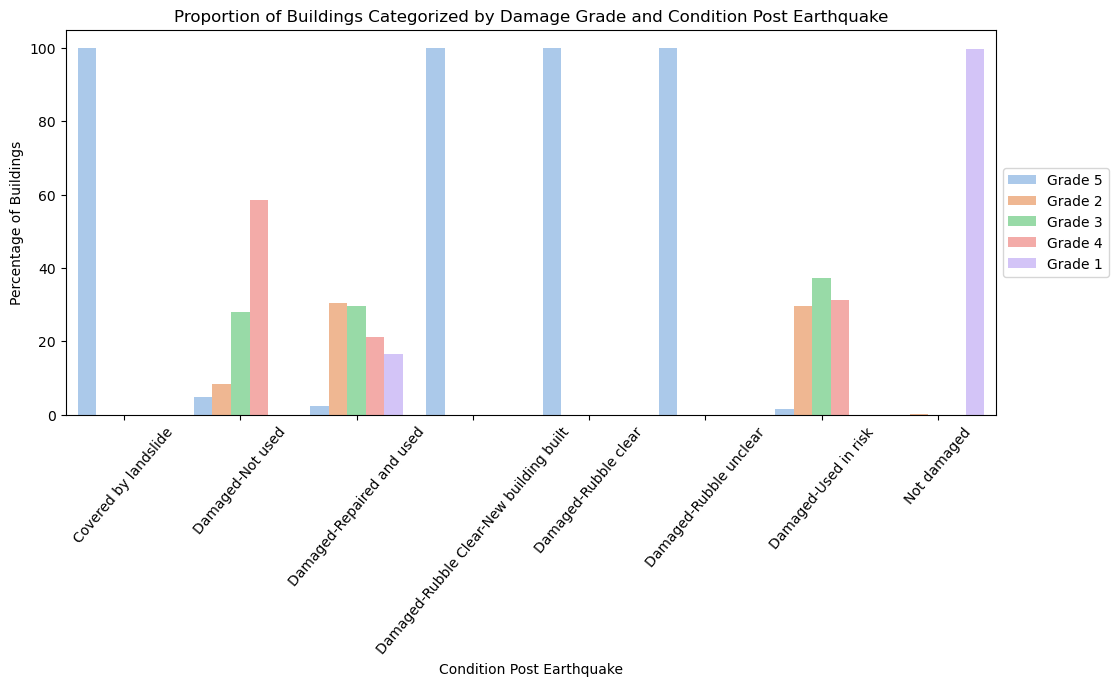

In [8]:
#Find the counts and set index
ndf3 = ndf.groupby(['condition_post_eq','damage_grade']).size().reset_index(name='count')
ndf3 = ndf3.set_index(['condition_post_eq', 'damage_grade'])

#Calculate grade proportion/percentage
ndf3 = ndf3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

#Make the chart look pretty
plt.figure(figsize=(12,5))

ax = sns.barplot(data = ndf3, x = 'condition_post_eq', y = 'count', hue = 'damage_grade', palette = "pastel")
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Proportion of Buildings Categorized by Damage Grade and Condition Post Earthquake")
plt.xlabel("Condition Post Earthquake")
plt.ylabel("Percentage of Buildings")
plt.show()

Given the histogram below, most buildings in the dataset appear to have a flat land surface type whereas the minority have a steep slope. This is surprising as I would have thought most buildings would've been on a steep slope given the magnitude of the damage.

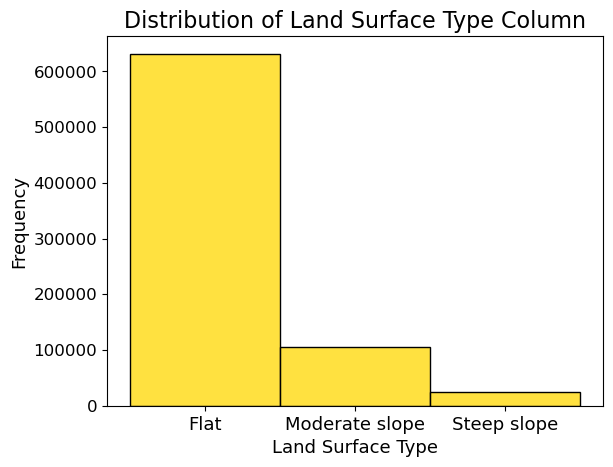

In [9]:
#View distribution of land surface condition column
plt.title('Distribution of Land Surface Type Column', size=16, color='black')
plt.xlabel('Land Surface Type', fontsize=13, color='black')
plt.ylabel('Frequency', fontsize=13, color='black')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
sns.histplot(ndf["land_surface_condition"], kde=False, color="gold")
plt.show()

Furthermore, the overwhelming majority of buildings in the dataset have a mud type of ground. This is interesting as research states that "The deeper the sediment layer above bedrock, the more soft soil there is for the seismic waves to travel through. Soft soil means bigger waves and stronger amplification" [4]. I'm curious to see if this could have been a major contributing factor to the damage grade for the Gorkha earhquake.

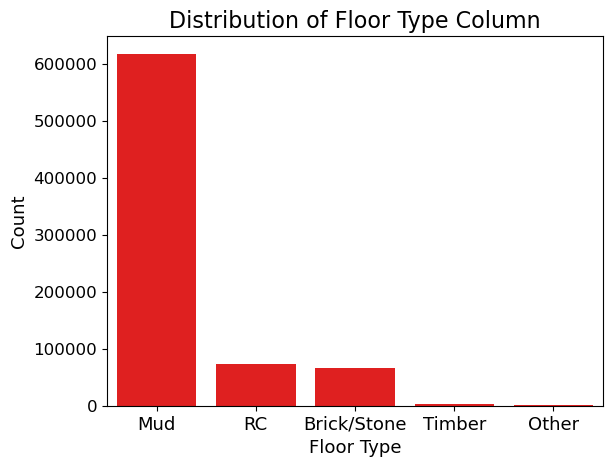

In [18]:
#View distribution of ground floor type column
#Get value counts
ndf['ground_floor_type'].value_counts()

dict1 = ({'Mud':618217, 'RC':73149, 'Brick/Stone':66093, 'Timber':3594, 'Other':1053})
ndf1 = pd.DataFrame(list(dict1.items()))
ndf1.columns =["Floor Type","Count"]

#Sort df by Count column
ndf1 = ndf1.sort_values(['Count'], ascending=False).reset_index(drop=True)

#View distribution of damage grade column
plt.title('Distribution of Floor Type Column', size=16, color='black')
plt.xlabel('Floor Type', fontsize=13, color='black')
plt.ylabel('Frequency', fontsize=13, color='black')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
sns.barplot(x = ndf1["Floor Type"], y = ndf1["Count"], color="red")
plt.show()

Most of the buildings had bamboo/timber-light roofs. Some buildings had a mix of bamboo/timber-heavy roofs as well as RCC/RB/RBC roofs. This isn't a major concern of mine as my gut tells me the roof type will not majorly impact the damage grade, but I was still curious to see the distribution.

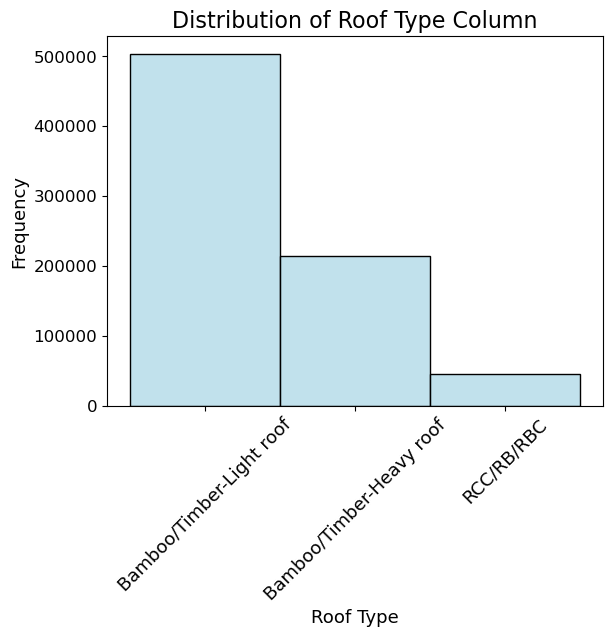

In [16]:
#View distribution of roof type column
plt.title('Distribution of Roof Type Column', size=16, color='black')
plt.xlabel('Roof Type', fontsize=13, color='black')
plt.ylabel('Frequency', fontsize=13, color='black')
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=12)
sns.histplot(ndf["roof_type"], kde=False, color="lightblue")
plt.show()

Unsurprisingly, the visual below shows the majority of buildings require reconstruction. This makes sense comparing with the damage grade distribution, as most buildings are in the fourth and fifth damage grade categories. Also worth noting from the below histogram is a very small amount of the buildings do not need any fixing.

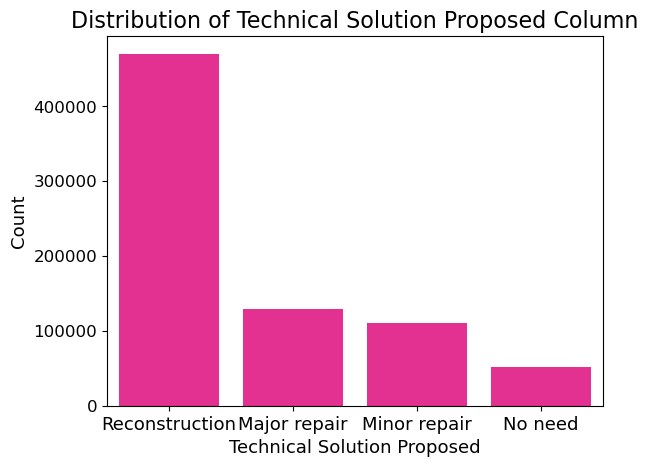

In [21]:
#View distribution of ground floor type column
#Get value counts
ndf['technical_solution_proposed'].value_counts()

dict1 = ({'Reconstruction':470231, 'Major repair':129415, 'Minor repair':110605, 'No need':51855})
ndf1 = pd.DataFrame(list(dict1.items()))
ndf1.columns =["Technical Solution Proposed","Count"]

#Sort df by Count column
ndf1 = ndf1.sort_values(['Count'], ascending=False).reset_index(drop=True)

#View distribution of damage grade column
plt.title('Distribution of Technical Solution Proposed Column', size=16, color='black')
plt.xlabel('Technical Solution Proposed', fontsize=13, color='black')
plt.ylabel('Frequency', fontsize=13, color='black')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
sns.barplot(x = ndf1["Technical Solution Proposed"], y = ndf1["Count"], color="deeppink")
plt.show()

Next, I wanted to look at the distribution of building height pre-earthquake versus post-earthquake to see how much the buildings collapsed/how much height they lost. As seen below, the most dramatic height difference is in damage grade 5, where the majority of buildings started out in the 10-20 feet range, but ended with 0 feet. Surprisingly damage grade 4 did not see much of a shift in terms of building height. On the other hand, I was not shocked to see damage grades 1-3 remain relatively the same.

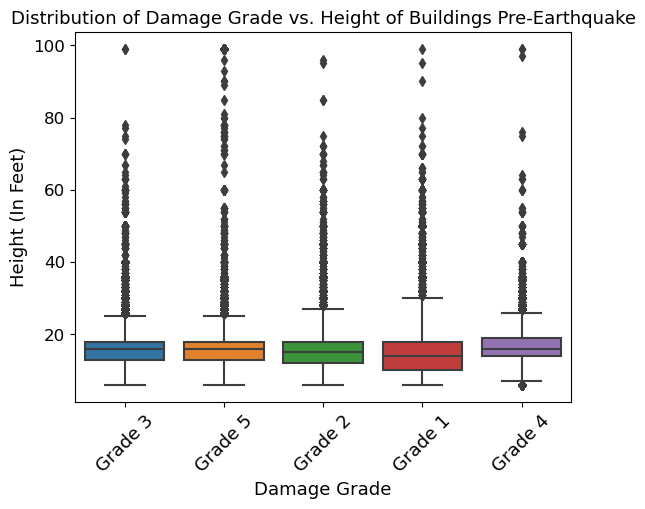

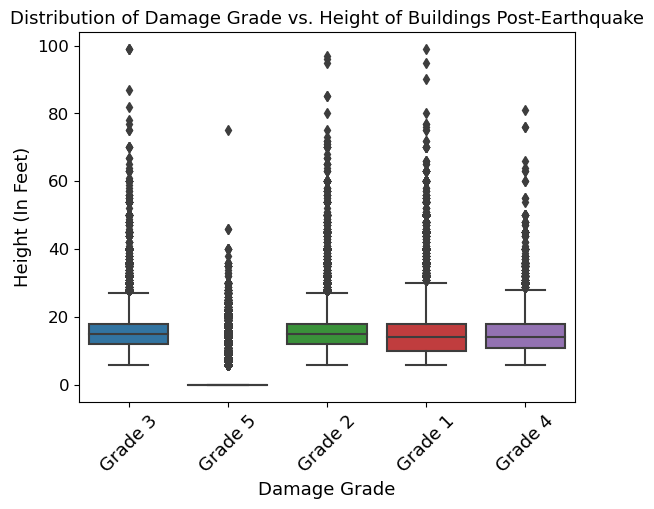

In [22]:
#Height of building post and pre earthquake by damage grade
sns.boxplot(x = ndf["damage_grade"], y = ndf["height_ft_pre_eq"], data=pd.melt(ndf))
plt.title('Distribution of Damage Grade vs. Height of Buildings Pre-Earthquake', size=13, color='black')
plt.xlabel('Damage Grade', fontsize=13, color='black')
plt.ylabel('Height (In Feet)', fontsize=13, color='black')
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=12)
plt.show()

sns.boxplot(x = ndf["damage_grade"], y = ndf["height_ft_post_eq"], data=pd.melt(ndf))
plt.title('Distribution of Damage Grade vs. Height of Buildings Post-Earthquake', size=13, color='black')
plt.xlabel('Damage Grade', fontsize=13, color='black')
plt.ylabel('Height (In Feet)', fontsize=13, color='black')
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=12)
plt.show()

Going hand in hand with the visuals above, I wanted to do the same thing but for count of floors pre- and post-earthquake. As seen below, the most dramatic floor count difference is in damage grade 5, where the majority of buildings started out in the 2-3 floors range, but ended with 0. Furthermore, damage grade 4 saw a slight decrease in floor count.

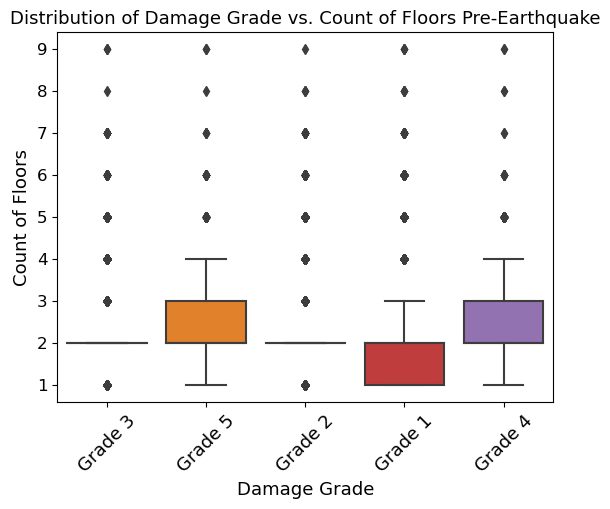

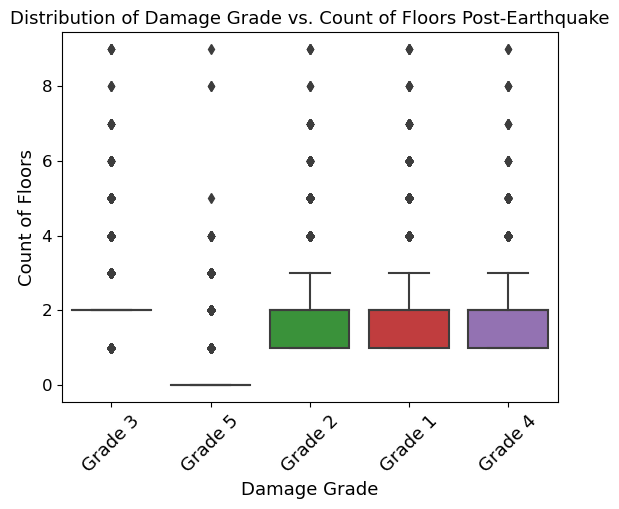

In [23]:
#Count of floors post and pre earthquake by damage grade
sns.boxplot(x = ndf["damage_grade"], y = ndf["count_floors_pre_eq"], data=pd.melt(ndf))
plt.title('Distribution of Damage Grade vs. Count of Floors Pre-Earthquake', size=13, color='black')
plt.xlabel('Damage Grade', fontsize=13, color='black')
plt.ylabel('Count of Floors', fontsize=13, color='black')
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=12)
plt.show()

sns.boxplot(x = ndf["damage_grade"], y = ndf["count_floors_post_eq"], data=pd.melt(ndf))
plt.title('Distribution of Damage Grade vs. Count of Floors Post-Earthquake', size=13, color='black')
plt.xlabel('Damage Grade', fontsize=13, color='black')
plt.ylabel('Count of Floors', fontsize=13, color='black')
plt.xticks(fontsize=13, rotation=45)
plt.yticks(fontsize=12)
plt.show()

The barplot below demonstrates that the older the building is, the more likely it is to be more damaged by the earthquake. Damage grades 4 and 5 have the oldest buildings on average (25+ years old) whereas damage grades 1 and 2 have newer buildings on average (~15-20 years old).

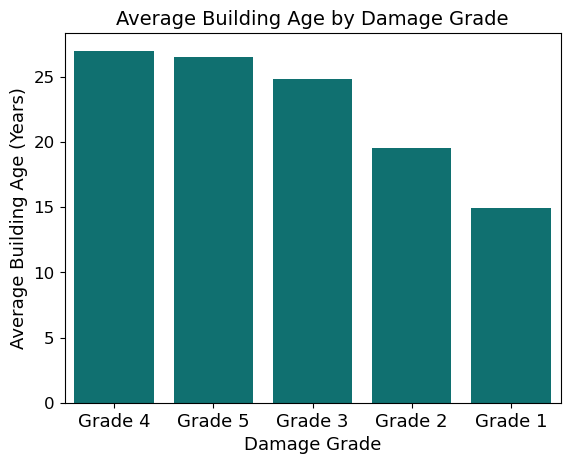

In [24]:
#Age of building by damage grade
b = ndf.groupby("damage_grade")["age_building"].mean().sort_values(ascending=False)[0:5]

b = b.reset_index().rename(columns={"damage_grade":"Damage Grade","age_building":"Building Age"})

sns.barplot(y = "Building Age", x = "Damage Grade", data=b, color="teal")

#Making the plot look pretty
plt.title('Average Building Age by Damage Grade', size=14, color='black')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.xlabel('Damage Grade', fontsize=13, color='black')
plt.ylabel('Average Building Age (Years)', fontsize=13, color='black')
plt.show()

The histogram below demonstrates that most buildings in the dataset have superstructures of mud, mortar, or stone. The second most common superstructure is timber. Worth noting is a superstructure is a structure built on top of something else, so this visual shows us that a lot of buildings in our dataset have add-ons made of mud, mortar, or stone.

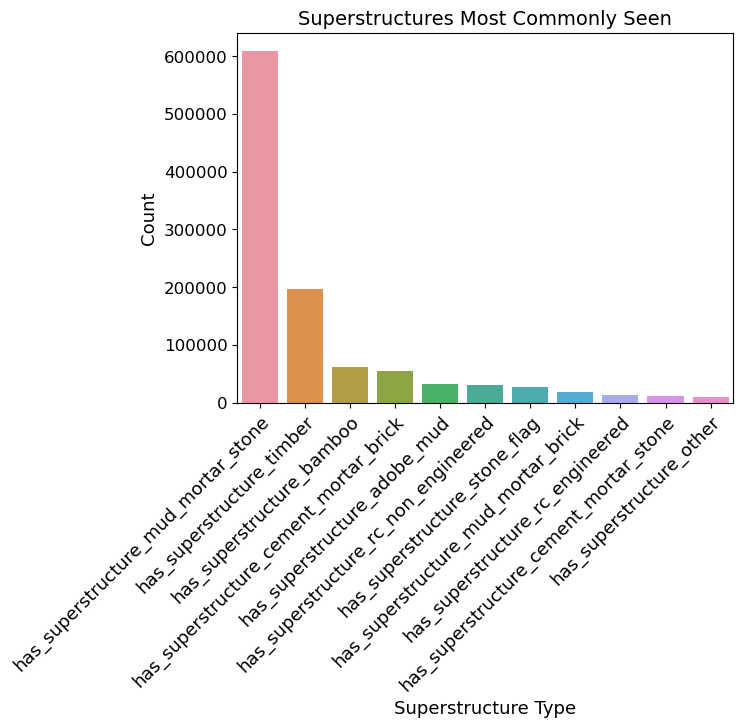

In [25]:
#Superstructure histogram data prep - what superstructures are most commonly listed
cols = ndf.loc[:, 'has_superstructure_adobe_mud':'has_superstructure_other']
sums = cols.sum().sort_values(ascending=False)

#Create histogram
fig, ax = plt.subplots(nrows=1, ncols=1)
a1 = sns.barplot(x=sums.index, y=sums)
    
#Making the plot look pretty
plt.title('Superstructures Most Commonly Seen', size=14, color='black')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.xlabel('Superstructure Type', fontsize=13, color='black')
plt.ylabel('Count', fontsize=13, color='black')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

The barplot below reinforces the idea that the older the building is, the more likely it is to be damaged. Building codes from older years (20+ years ago) may not have been as good as they are now, so this makes sense. The "not damaged" column has on average the youngest building age of the different condition post-earthquake categories.

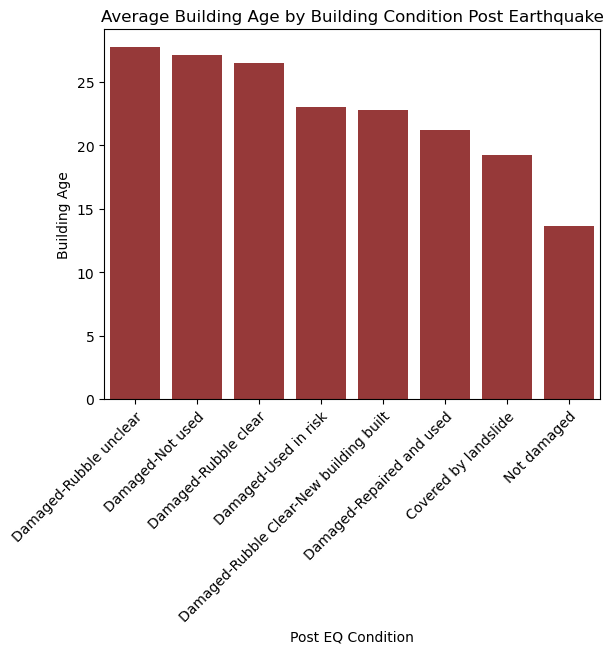

In [26]:
#Condition post eq vs age building
fig, ax = plt.subplots(nrows=1, ncols=1)

c = ndf.groupby("condition_post_eq")["age_building"].mean().sort_values(ascending=False)[0:8]

r = c.reset_index().rename(columns={"condition_post_eq":"Post EQ Condition","age_building":"Building Age"})

sns.barplot(y = "Building Age", x = "Post EQ Condition", data=r, color="brown")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.title("Average Building Age by Building Condition Post Earthquake")
plt.show()

I also created a violin plot to show the relationship between building height post-earthquake and foundation type. It appears most of the buildings with mud mortar-stone/brick foundations had the lowest building height after the earthquake. However, bamboo/timber foundations had the most buildings around the 20 feet range. RC also looks fairly evenly distributed with a good amount of buildings being around 10-40 feet.

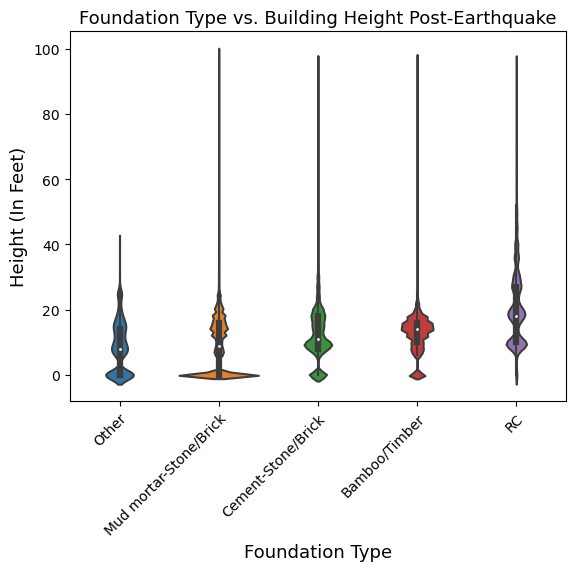

In [27]:
#Violin plot of foundation type by height post EQ
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

sns.violinplot(x = ndf['foundation_type'], y = ndf['height_ft_post_eq'])
plt.title('Foundation Type vs. Building Height Post-Earthquake', size=13, color='black')
plt.xlabel('Foundation Type', fontsize=13, color='black')
plt.ylabel('Height (In Feet)', fontsize=13, color='black')
plt.show()

Lastly, I realized I hadn't looked at building position yet so I created a side-by-side bar graph of the percentage of buildings categorized by damage grade and position. The majority of buildings which were attached at 1 side were in the damage grade 5 category, whereas buildings which were attached at 3 sides had the lowest amount of damage grade 5 categorizations and the highest amount of damage grade 1 categorizations. Thus, it could be the case that attachments at the sides of buildings may help prevent some of the damage in the event of an earthquake but further research would be needed to know for sure.

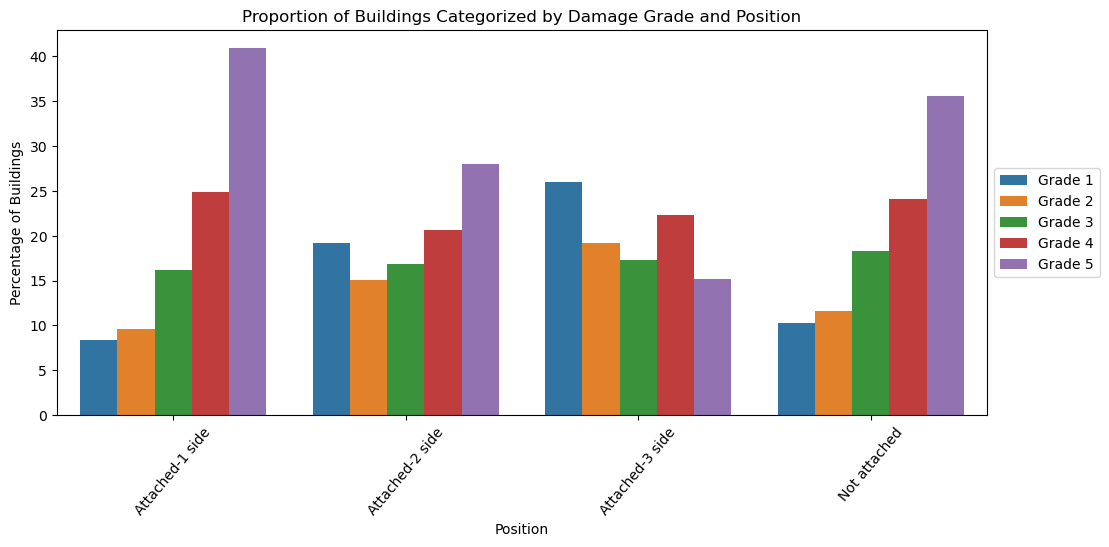

In [28]:
#Find the counts and set index
ndf2 = ndf.groupby(['position','damage_grade']).size().reset_index(name='count')
ndf2 = ndf2.set_index(['position', 'damage_grade'])

#Calculate grade proportion/percentage
ndf2 = ndf2.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

#Make the chart look pretty
plt.figure(figsize=(12,5))
ax = sns.barplot(data = ndf2, x = 'position', y = 'count', hue = 'damage_grade')
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Proportion of Buildings Categorized by Damage Grade and Position")
plt.xlabel("Position")
plt.ylabel("Percentage of Buildings")
plt.show()

To summarize my findings above, most buildings in the dataset appear to have suffered significant damage from the earthquake, have a flat land surface type, mud/mortar/stone/brick foundation type, mud/mortar/stone superstructure type, mud ground floor type, bamboo/timber-light type roof, are older in age, and need to undergo total reconstruction as a technical solution due to the damage. Seeing how these variables come into play in the model build out will be very interesting.

## Data Pre-Processing For Model Build-Out

I began by using a random sample of 1000 observations from each class, (in total 5000 observations), to ensure my models ran and to also address the class imbalance issue. Next, I checked for multicollinearity among the predictor variables which led to me removing two of them (count of floors post- and pre-earthquake were very related to height of the building post- and pre-earthquake). I also removed three variables that were clearly related to damage grade which were: technical solution proposed, height of the building post earthquake, and condition of the building post earthquake. I then seperated out my predictor variables from my dependent variable, damage grade. Next, I label encoded my dependent variable, converted building ID, ward ID, and municipality ID to object type, removed any outliers within a specific range, one-hot encoded  my categorical predictor variables, and removed any variables with near-zero variance. Once these steps were complete, I then divided my data into training and testing sets for the model buildout portion.

In [12]:
#Random sample of 5000 to make sure it runs
classes = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5']

partitions = []
for c in classes:
    partition = ndf[ndf['damage_grade'] == c]
    partitions.append(partition.sample(n = 1000, random_state=42))
    
ndf1 = pd.concat(partitions)

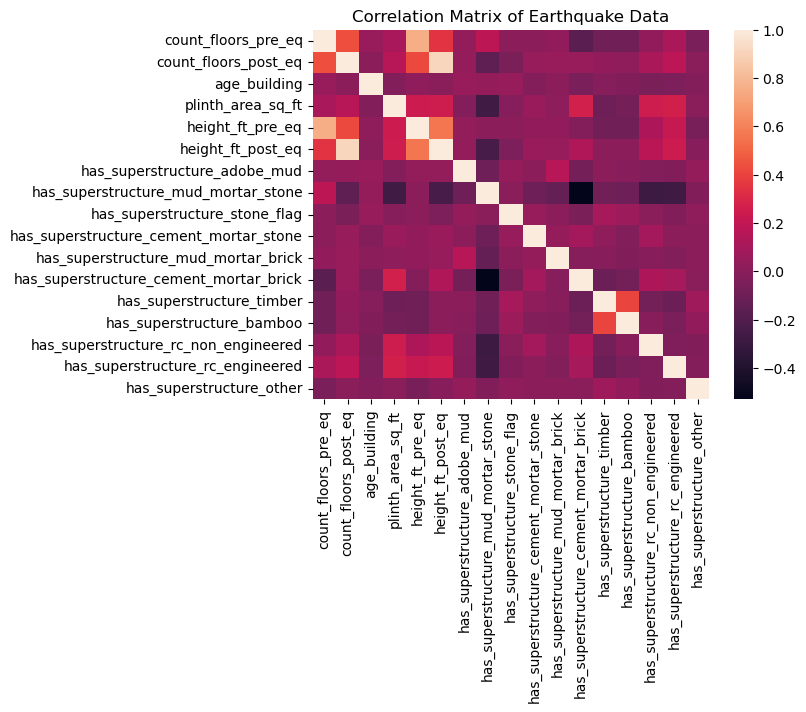

In [13]:
#Correlation matrix of 5000 samples
corr_matrix = ndf1.corr()

sns.heatmap(corr_matrix, annot=False)
plt.title("Correlation Matrix of Earthquake Data")
plt.show()

In [14]:
#Removing count of floors post- & pre-earthquake because of multicollinearity
ndf1 = ndf1.drop(['count_floors_pre_eq', 'count_floors_post_eq'], axis = 1)

In [15]:
#Seperate out x and y and drop variables that could be related to damage_grade
x = ndf1.drop(['damage_grade', 'technical_solution_proposed', 'height_ft_post_eq', 
               'condition_post_eq'], axis=1)
y = ndf1['damage_grade']

In [16]:
#Target var transformer
y_preprocess = LabelEncoder()
y = y_preprocess.fit_transform(y)

In [17]:
#X's processing
#Identify columns
obj_cvts = ['district_id_x', 'vdcmun_id_x', 'ward_id']
outlier = ['age_building']
cat = ndf1.drop(obj_cvts, axis = 1).select_dtypes(include=['object']).drop(['damage_grade', 
               'technical_solution_proposed', 'condition_post_eq'], axis = 1).columns

#Convert a column to an object type
def convert_object(x):
    return pd.DataFrame(x).astype(object)

to_object = Pipeline(steps = [('convert_object', FunctionTransformer(convert_object))])

#Restrict outliers
res_outlier = Pipeline(steps = [('Outlier_scaler', RobustScaler(quantile_range = (0,0.9)))])

#One-hot encoding
one_hot = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Near zero variance
nzv1 = Pipeline(steps = [('nzv', VarianceThreshold(threshold = 0.01))])

#Create one preprocessing step for our x's
preprocessing_xs = ColumnTransformer(
    transformers = [
        ('convert_object', to_object, obj_cvts), 
        ('Outlier', res_outlier, outlier),  
        ('cat', one_hot, cat), 
        ('nzv', nzv1,[])
    ])
      
#Apply transformations to predictor vars
x = preprocessing_xs.fit_transform(x)

In [18]:
#Split training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, 
                                                    stratify = y, shuffle=True)

## Model Build-Out

Assumptions for each model are listed below. Once the assumptions were addressed, I then created Support Vector Machine (SVM), Random Forest, and k-Nearest Neighbors classification models. I performed a grid search for each model to find the optimal tuning parameters. Next, I evaluated each model's performance by looking at their accuracy and precision scores as well as a confusion matrix for each. However, accuracy was my main metric I judged the models by. Overall, SVM performed the best in terms of accuracy (approximately 0.42) and precision (approximately 0.40). The performance of each model will be discussed more in the following section.

#### Assumptions for SVM

SVM does not have any distributional assumptions we must make. However, two assumptions worth noting are the distance from the classification boundary to the nearest data point should be as large as possible, and the support vectors must be the most useful data points because they are the ones most likely to be inaccurately classified.

#### Assumptions for Random Forest

Random Forests are non-parametric, so normality is not needed as an assumption. However, the predictions from each tree have to have very low correlations. Also there must be actual values in the feature variables of the dataset, which will provide the classifier with a better likelihood to predict accurate results.

#### Assumptions for kNN

kNN is also a non-parametric model which does not have any underlying distributional assumptions in order to use the algorithm/model. However, we will assume that data points/instances which exist in close proximity to each other are very similar.

In [19]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#kNN 
#Tuning parameters
param_grid = {
    'leaf_size': [1, 2, 3],
    'n_neighbors': [1, 2, 3, 4],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

knn_clf = GridSearchCV(knn, param_grid)
knn_clf.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 2, 3], 'n_neighbors': [1, 2, 3, 4],
                         'p': [1, 2]})

In [20]:
#kNN
print("Best parameters and score:", knn_clf.best_score_)
print(knn_clf.best_params_)

Best parameters and score: 0.403
{'leaf_size': 1, 'n_neighbors': 4, 'p': 1}


In [21]:
#Random Forest
#Tuning parameters
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 4, 5],
    'max_leaf_nodes': [3, 4, 5]
}

#Fitting the model
rnd_clf = GridSearchCV(RandomForestClassifier(random_state=7), param_grid)
rnd_clf.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=7),
             param_grid={'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 4, 5],
                         'n_estimators': [25, 50, 100]})

In [22]:
#Random Forest
print("Best parameters and score:", rnd_clf.best_score_)
print(rnd_clf.best_params_)

Best parameters and score: 0.414
{'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 5, 'n_estimators': 100}


In [23]:
#SVM
#Parameter grid
param_grid = {'svm__C': [0.1, 1, 10, 100, 1000], 
              'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'svm__kernel': ['rbf']} 
  
pipe = Pipeline([("svm", SVC())])
    

model_svm = GridSearchCV(pipe, param_grid)
  
#Fitting the model
model_svm.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 10, 100, 1000],
                         'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svm__kernel': ['rbf']})

In [24]:
#SVM
print("Best parameters and score:", model_svm.best_score_)
print(model_svm.best_params_)

Best parameters and score: 0.4425
{'svm__C': 1000, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}


In [25]:
#Performance metrics
#Accuracy score
y_pred_knn = knn_clf.predict(x_test)
print("kNN:", accuracy_score(y_test, y_pred_knn))
y_pred_svm = model_svm.predict(x_test)
print("SVM:", accuracy_score(y_test, y_pred_svm))
y_pred_rnd = rnd_clf.predict(x_test)
print("Random Forest:", accuracy_score(y_test, y_pred_rnd))

kNN: 0.398
SVM: 0.417
Random Forest: 0.413


In [26]:
#Precision score
y_pred_knn = knn_clf.predict(x_test)
print("kNN:", precision_score(y_test, y_pred_knn, average='weighted'))
y_pred_svm = model_svm.predict(x_test)
print("SVM:", precision_score(y_test, y_pred_svm, average='weighted'))
y_pred_rf = rnd_clf.predict(x_test)
print("Random Forest:", precision_score(y_test, y_pred_rf, average='weighted'))

kNN: 0.3884850169238518
SVM: 0.400849654442499
Random Forest: 0.37560001000183346


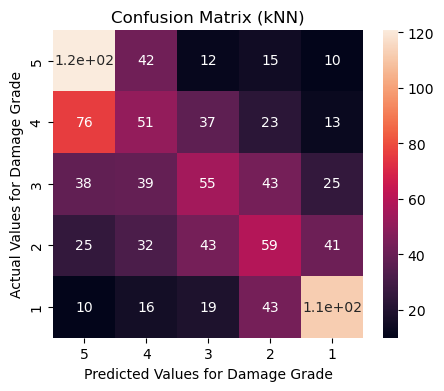

In [27]:
#KNN
cm = confusion_matrix(y_test, y_pred_knn)

#Creating a dataframe for a confusion matrix
cm_df = pd.DataFrame(cm,
                     index = ['5', '4','3','2', '1'], 
                     columns = ['5', '4','3','2', '1'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix (kNN)')
plt.ylabel('Actual Values for Damage Grade')
plt.xlabel('Predicted Values for Damage Grade')
plt.show()

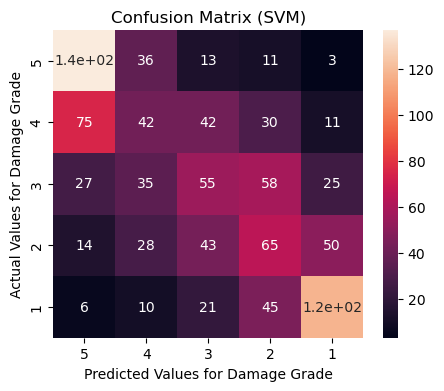

In [28]:
#SVM
cm = confusion_matrix(y_test, y_pred_svm)

#Creating a dataframe for a confusion matrix
cm_df = pd.DataFrame(cm,
                     index = ['5', '4','3','2', '1'], 
                     columns = ['5', '4','3','2', '1'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix (SVM)')
plt.ylabel('Actual Values for Damage Grade')
plt.xlabel('Predicted Values for Damage Grade')
plt.show()

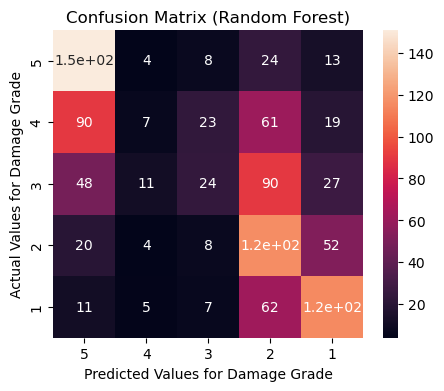

In [29]:
#Random forest
cm = confusion_matrix(y_test, y_pred_rf)

#Creating a dataframe for a confusion matrix
cm_df = pd.DataFrame(cm,
                     index = ['5', '4','3','2', '1'], 
                     columns = ['5', '4','3','2', '1'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual Values for Damage Grade')
plt.xlabel('Predicted Values for Damage Grade')
plt.show()

## Conclusion

Overall, the scores for the various performance metrics were not great. I was hoping for at least 70-80% accuracy and precision. However, as this is a real-world dataset and was relatively messy, I think the accuracy scores of around 40% on average were fairly realistic given the input. With that being said, the SVM model performed the best in terms of accuracy. Random forest performed the second best and the kNN model performed the worst in terms of accuracy. My random forest and SVM models seemed to do the best at correctly classifying damage grade 1 buildings, but my kNN and SVM models looked like they did the best as a whole in terms of classifying damage grades correctly when I looked at the confusion matrices. I also thought it would be helpful (as the scores for the metrics were so low), to look at the difference between random chance and the output from my SVM model. I created a model that randomly guesses the damage grade level and compared its accuracy to my SVM model output. The difference showed that the model was approximately 25% better than random chance, which demonstrates that my model was in fact able to pick up on some patterns in the data. 

In terms of practical application, I thought it would be interesting to compare how the random forest model ranked the variables in terms of variable importance versus my SVM model's variable rankings. SVM told us that the building having a superstructure of mud, mortar, or stone was the most positively correlated variable to damage grade level. District, municipality, age of the building, plinth area, and height pre-earthquake also seemed to be important as well. The random forest model provided similar results for variable importance. The top five most important variables in descending order were: the building having a superstructure of mud, mortar, or stone, district name, ground floor type, other floor type, and foundation type for the building. Overall, these variables are all things architects, civil engineers, FEMA, etc. should pay attention to when building structures/creating guidelines as a building may be less vulnerable to drastic earthquake damage when taking these factors into consideration. 

In [30]:
#Random chance comparison
import random

damage_grade = [1, 2, 3, 4, 5]
def random_damage():
    return random.choice(damage_grade)

def random_model(n):
    return np.array([random_damage() for _ in range(n)])

print("Random Choice Precision Score:", precision_score(y_test, random_model(y_test.shape[0]), average='weighted'))
print("Random Choice Accuracy Score:", accuracy_score(y_test, random_model(y_test.shape[0])))

Random Choice Precision Score: 0.14509931861814607
Random Choice Accuracy Score: 0.167


/Users/allisonking/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Variables Ranked by Importance SVM Model')

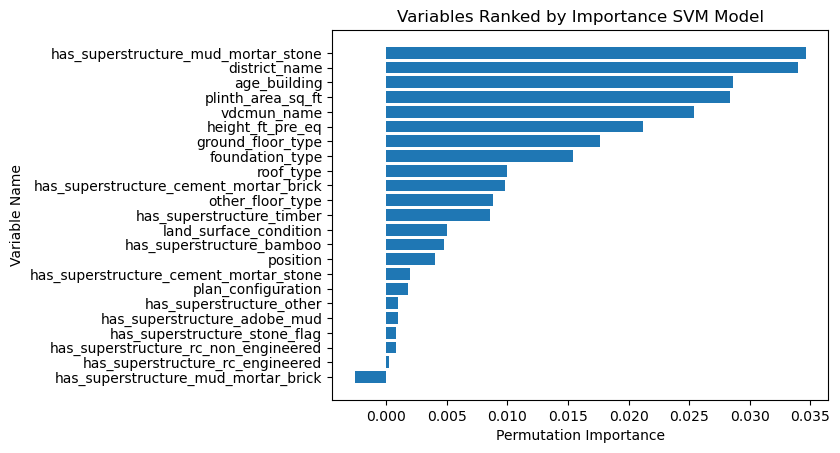

In [31]:
#Create new x and y 
x1 = ndf1.drop(['damage_grade', 'building_id', 'district_id_x', 'vdcmun_id_x', 'ward_id',
               'technical_solution_proposed', 'height_ft_post_eq', 'condition_post_eq'], axis=1)
y1 = ndf1['damage_grade']

#Label encoder for categorical features
le = LabelEncoder()
y2 = le.fit_transform(y1)
x1['land_surface_condition'] = le.fit_transform(x1['land_surface_condition'])
x1['foundation_type'] = le.fit_transform(x1['foundation_type'])
x1['roof_type'] = le.fit_transform(x1['roof_type'])
x1['ground_floor_type'] = le.fit_transform(x1['ground_floor_type'])
x1['other_floor_type'] = le.fit_transform(x1['other_floor_type'])
x1['position'] = le.fit_transform(x1['position'])
x1['plan_configuration'] = le.fit_transform(x1['plan_configuration'])
x1['vdcmun_name'] = le.fit_transform(x1['vdcmun_name'])
x1['district_name'] = le.fit_transform(x1['district_name'])

#List of feature names
features_names = ['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq', 'land_surface_condition' , 
                  'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
                  'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 
                  'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
                  'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
                  'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 
                  'has_superstructure_rc_engineered', 'has_superstructure_other', 'vdcmun_name', 'district_name']


#Split training and testing sets
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y2, test_size = 0.2, random_state = 42, 
                                                    stratify = y2, shuffle=True)

#Use optimal parameters found in previous SVM grid search
svc =  SVC(kernel='rbf', C= 1000, gamma= 0.0001)
svc.fit(x1_train, y1_train)

perm_importance = permutation_importance(svc, x1_test, y1_test)

features = np.array(features_names)

#Plot variable importance for SVM
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.ylabel("Variable Name")
plt.title("Variables Ranked by Importance SVM Model")

Text(0, 0.5, 'Variable Name')

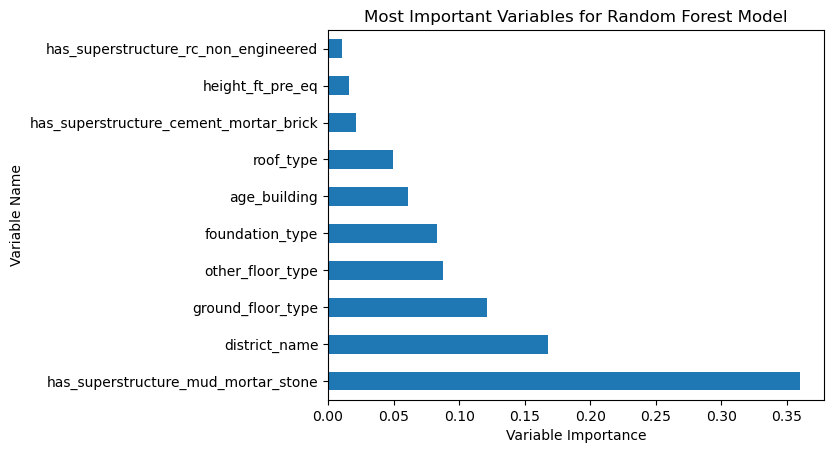

In [32]:
#Seperate out x and y and creae random forest model using optimal tuning params
rnd = RandomForestClassifier(n_estimators=25, max_leaf_nodes= 5, max_depth = 3, random_state=7)
x1 = ndf1.drop(['damage_grade', 'building_id', 'district_id_x', 'vdcmun_id_x', 'ward_id',
               'technical_solution_proposed', 'height_ft_post_eq', 'condition_post_eq'], axis=1)
y1 = ndf1['damage_grade']

#Label encoder
le = LabelEncoder()
y2 = le.fit_transform(y1)
x1['land_surface_condition'] = le.fit_transform(x1['land_surface_condition'])
x1['foundation_type'] = le.fit_transform(x1['foundation_type'])
x1['roof_type'] = le.fit_transform(x1['roof_type'])
x1['ground_floor_type'] = le.fit_transform(x1['ground_floor_type'])
x1['other_floor_type'] = le.fit_transform(x1['other_floor_type'])
x1['position'] = le.fit_transform(x1['position'])
x1['plan_configuration'] = le.fit_transform(x1['plan_configuration'])
x1['vdcmun_name'] = le.fit_transform(x1['vdcmun_name'])
x1['district_name'] = le.fit_transform(x1['district_name'])


rnd.fit(x1, y2)
rnd.feature_importances_
my_list = x1.columns.values.tolist()
#for name, score in zip(my_list, rnd.feature_importances_):
#    print(name, score)

#Plot feature importance
(pd.Series(rnd.feature_importances_, index=x1.columns).nlargest(10).plot(kind='barh', 
                                    title="Most Important Variables for Random Forest Model")) 
plt.xlabel("Variable Importance")
plt.ylabel("Variable Name")

### References


[1] PreventionWeb. Nepal: Gorkha Earthquake 2015. https://www.preventionweb.net/collections/nepal-gorkha-earthquake-2015

[2] FEMA. Seismic Building Codes. https://www.fema.gov/emergency-managers/risk-management/earthquake/seismic-building-codes

[3] Optimum Seismic. Why Do Buildings Fail In An Earthquake? https://www.optimumseismic.com/earthquakes/why-do-buildings-fail-in-an-earthquake/#:~:text=Here%20in%20California%2C%20there%20are,moment%20frame%2C%20and%20unreinforced%20masonr

[4] WRSB. The Effects of Soil Type on Earthquake Damage. https://www1.wsrb.com/blog/the-effects-of-soil-type-on-earthquake-damage